<a href="https://colab.research.google.com/github/ShivinM-17/Tensorflow_practises/blob/main/Milestone_2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone project 2: SkimLit

The purpose of the project is to build a NLP model to make reading medical abstracts easier.

### Confirm access to GPU

In [ ]:
# checking for GPU
!nvidia-smi

Fri Dec  1 05:52:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Getting the PubMed RCT 200k datasets

Dataset is available at: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
# Cloning the github repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 41.53 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Checking the files in the repo
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Checking files in the dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


Here, the dev.txt can be considered as a validation set

In [ ]:
# Starting the experiments using the 20k dataset with numbers replaced by '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# Check all the files in target directory
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Preprocess data

Here, data will be preprocessed and visualized to learn more about the data we are going to work upon.

Making a function to read all lines present in the text file

In [ ]:
# Create the function to read files in the document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, 'r') as file:
    return file.readlines()

In [ ]:
# Reading the training lines
train_lines = get_lines(data_dir+'train.txt')  # reading only the lines in the training directory
train_lines[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
# Checking the count of the training lines data
len(train_lines)

210040

Since, we cannot use the data text as is, therefore there is a need to represent and structure data appropriately.

This is how the lines will be represented.

```
[
  {
    'line_number':0,
    'target': 'OBJECTIVE',
    'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain
            , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained
            at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
    'total_lines': 12
  },
  {.....},
  {.....},
  ....
]

```

In [ ]:
# Making a function to create the above structure using the text data

def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its content and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename)  # get all lines from filename
  abstract_lines = ""   # Create a empty abstract
  abstract_samples = []  # empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'):   # check if the line is the 'id' line
      abstract_id = line
      abstract_lines = ""   # reset the abstract lines, if the line is 'id'
    elif line.isspace():  # Check if the line is a 'newline'
      abstract_line_split = abstract_lines.splitlines()  # split abstract into seperate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}  # Create empty diictionary for each line
        target_text_split = abstract_line.split('\t')  # split target label from text
        line_data['target'] = target_text_split[0]  # get target label
        line_data['text'] = target_text_split[1].lower()  # lowercase the target text
        line_data['line_number'] = abstract_line_number  # no. of the appearance of the line
        line_data['total_lines'] = len(abstract_line_split) - 1   # total lines present in the target abstract
        abstract_samples.append(line_data)  # add line data to abstract samples list

    else:  # if above conditions not fulfilled, the line contains a labeled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get the data from the file and structure it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 734 ms, sys: 94.5 ms, total: 829 ms
Wall time: 1.06 s


In [ ]:
# Check the first abstract of the training data
train_samples[:15]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Turning the data (present as list of dictionaries), and turning it into a DataFrame for further visualisation

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of the labels in the training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

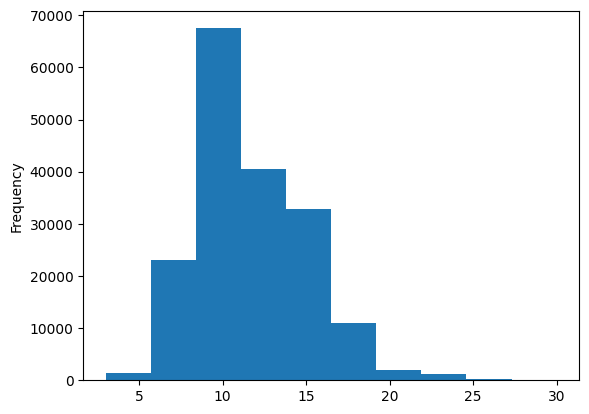

In [ ]:
# Checking out the length of different lines
train_df.total_lines.plot.hist()

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of the training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Making numeric labels, since ML models require numeric data as well as labels.

#### One-hot encoding the labels

In [ ]:
# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)  # non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

# Checking the one-hot encoded labels
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

`NOTE`: if we put `sparse-output` of the OneHotEncoder as `True`, and transform the data by reshaping it, an error occurs, since tensorflow doesn't allow for a sparse matrix.

Therefore, using `sparse-output = False`, will work fine with tensorflow.

#### Label encode the labels

In [ ]:
# Extract labels ('target' columns) and encode them into intergers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# Check what the training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and numner of classes from the LabelEncoder instances
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Baseline model 0 : tf-idf naive bayes model

In [ ]:
# Import the necessary packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Making predictions using the baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

#### Downloading the helper functions script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-01 05:53:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-12-01 05:53:02 (13.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing the data text for deep sequence models

To use the data in the networks, the text data must be vectorized and embedded


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

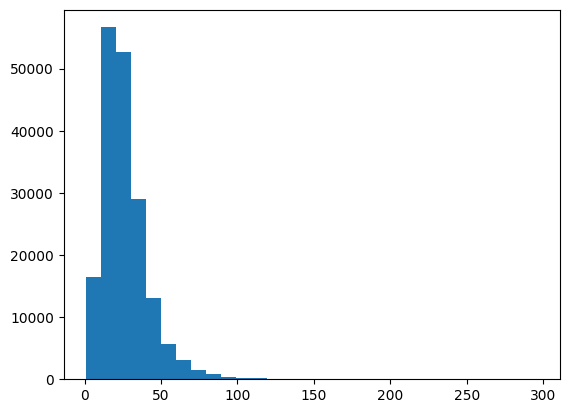

In [ ]:
# Checking the distribution of the sentence lengths
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=30)

In [ ]:
# Checking what length of the text samples cover 95% of the whole data
# This is done to check and confirm, whether there is any need for padding or any other parameter value in the preprocessing part
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Checking out the maximum sequence length
max(sent_lens)

296

#### Create text vectorizer layer

This layer maps the text words to numbers

In [ ]:
# Count of words in the vocab
max_tokens = 68000

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,  # no. of words in the vocab
                                    output_sequence_length = output_seq_len
                                    )

In [ ]:
# Adapt text vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
an increased creatine kinase isoenzyme mb level of greater than two times the upper limit of normal was found in @ cases ( @ % ) in group @ and @ cases ( @ % ) in group @ , without a statistically significant difference between the two groups ( p = @ ) .

Length of text: 254

Vectorized text: [[   26    96  3606  2668 12052  5195   204     4   182    42    51   361
      2   763  1877     4   417    10   208     5   263     5    13     3
    263     5    13   159     8   232    37    74    30     2    51    24
     14     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in the training vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the configuration of the text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab),  # Length of the vocab
                               output_dim = 128,
                               mask_zero = True,  # use masking variable seq length
                               name = 'token_embedding'
                               )

In [ ]:
# Checking out example embedding
print(f"Sentence before vectorization:\n {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 an increased creatine kinase isoenzyme mb level of greater than two times the upper limit of normal was found in @ cases ( @ % ) in group @ and @ cases ( @ % ) in group @ , without a statistically significant difference between the two groups ( p = @ ) .
Sentence after vectorization (before embedding):
 [[   26    96  3606  2668 12052  5195   204     4   182    42    51   361
      2   763  1877     4   417    10   208     5   263     5    13     3
    263     5    13   159     8   232    37    74    30     2    51    24
     14     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.00069206  0.02462295  0.0363144  ... -0.03324934 -0.04467149
   -0.00095812]
  [-0.02327539  0.02653365  0.02507526 ...  0.02285491 -0.00818788
    0.00732011]
  [ 0.00745528  0.0330444   0.04094434 ...  0.02689466  0.00822414
    0.03474592]
  ...
  [ 0.00600761 -0.00560611  0.04819879

### Creating datasets (making sure that the data loads as fast as possible)

To setup the data to run as fast as possible, we will use the TensorFlow tf.data API

In [ ]:
# Turn the data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape

(180040, 5)

In [ ]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)   # condense the output of the feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),  # look at only 10% data of each batch
                              epochs = 5,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))  # Validate only on 10% data of the batches

Epoch 1/5
562/562 [==============================] - 36s 45ms/step - loss: 0.9207 - accuracy: 0.6388 - val_loss: 0.6790 - val_accuracy: 0.7414
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.6516 - accuracy: 0.7600 - val_loss: 0.6292 - val_accuracy: 0.7723
Epoch 3/5
562/562 [==============================] - 7s 12ms/step - loss: 0.6116 - accuracy: 0.7771 - val_loss: 0.5926 - val_accuracy: 0.7822
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5855 - accuracy: 0.7907 - val_loss: 0.5778 - val_accuracy: 0.7849
Epoch 5/5
562/562 [==============================] - 7s 13ms/step - loss: 0.5889 - accuracy: 0.7933 - val_loss: 0.5604 - val_accuracy: 0.7949


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.5596 - accuracy: 0.8009


[0.5596103668212891, 0.8009068965911865]

In [ ]:
# Make predictions (model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[5.5467296e-01, 1.5729021e-01, 3.7892368e-02, 1.9085403e-01,
         5.9290398e-02],
        [4.3930781e-01, 3.5986042e-01, 2.3745969e-02, 1.3306929e-01,
         4.4016488e-02],
        [2.1369541e-01, 5.4775104e-03, 1.7878676e-03, 7.7899688e-01,
         4.2270000e-05],
        ...,
        [4.9428159e-05, 5.3103548e-04, 5.2234582e-03, 4.2842690e-05,
         9.9415320e-01],
        [8.3916530e-02, 2.9459026e-01, 1.0758592e-01, 4.7241408e-02,
         4.6666589e-01],
        [1.5463640e-01, 7.2969848e-01, 7.3743828e-02, 1.7164072e-02,
         2.4757180e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate model_1 resultss
model_1_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_1_preds)
model_1_results

{'accuracy': 80.09069244009002,
 'precision': 0.8007064927609412,
 'recall': 0.8009069244009003,
 'f1': 0.7977112436277302}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

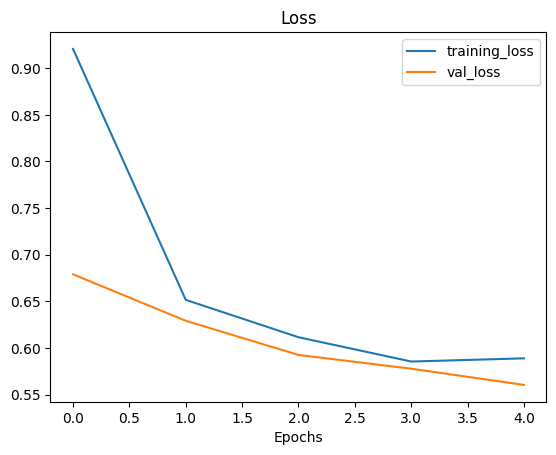

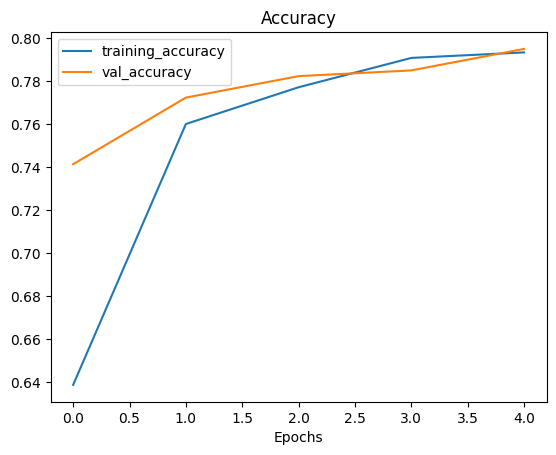

In [ ]:
# Plotting the loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(history_model_1)

### Model 2: Feature extraction with pretrained token embeddings

Using the pretrained word embeddings model from TensorFlow Hub, i.e., the Universal Sentence Encoder (USE)

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0]}\n")
print(f"Length of the sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 when compared to primary laiv infection , the decreased frequency of shedding with the iiv-laiv schedule was significant ( p = @ ) .
Sentence after embedding:
 [ 0.01437847 -0.0591423   0.04776993 -0.02614251  0.03358395 -0.03928393
  0.06401483 -0.05867644  0.07604687  0.04975874  0.07672901  0.04881144
 -0.01345854  0.00885304  0.06599333 -0.00686608 -0.06969879  0.00436674
  0.0165816   0.00907581 -0.07771074  0.05110228  0.009026    0.02577718
  0.06181502 -0.04303194 -0.06100222 -0.07231792 -0.04947185  0.05540985
  0.01889705  0.0826498  -0.06391697 -0.01268098 -0.01932621 -0.00302836
 -0.02121668 -0.04281286 -0.01293889  0.00851417  0.06756604  0.06699634
  0.0698111   0.05290512 -0.06072445 -0.04008758  0.02321908 -0.03796558
 -0.05077285 -0.00621533 -0.01312735  0.01978885  0.00265117 -0.06167827
  0.05513427  0.01720469 -0.07877275  0.01497599  0.07175665 -0.00182441
 -0.03613386 -0.05586327  0.05122238  0.0204862   0.03031732 -0.02303171
  0.03051287 -0.009

#### Building and fitting the NLP feature extraction model using the pretrained embeddings

In [ ]:
# Define the feature extraction model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)  # tokenize text and create embedding of a sequence of length 512
x = layers.Dense(128, activation='relu')(pretrained_embedding)
x = layers.Dense(64, activation='relu')(pretrained_embedding)
x = layers.GlobalAveragePooling1D()(tf.expand_dims(x, axis=1))
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_2 = tf.keras.Model(inputs = inputs,
                         outputs = outputs,
                         name = "model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 tf.expand_dims (TFOpLambda  (None, 1, 64)             0         
 )                                                               
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                     

In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs = 5,
                              steps_per_epoch = int(0.2*len(train_dataset)),
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/5
1125/1125 [==============================] - 20s 14ms/step - loss: 0.8691 - accuracy: 0.6648 - val_loss: 0.7654 - val_accuracy: 0.7041
Epoch 2/5
1125/1125 [==============================] - 15s 14ms/step - loss: 0.7517 - accuracy: 0.7101 - val_loss: 0.7319 - val_accuracy: 0.7171
Epoch 3/5
1125/1125 [==============================] - 18s 16ms/step - loss: 0.7468 - accuracy: 0.7142 - val_loss: 0.7087 - val_accuracy: 0.7251
Epoch 4/5
1125/1125 [==============================] - 20s 18ms/step - loss: 0.7052 - accuracy: 0.7299 - val_loss: 0.6804 - val_accuracy: 0.7397
Epoch 5/5
1125/1125 [==============================] - 19s 17ms/step - loss: 0.6927 - accuracy: 0.7356 - val_loss: 0.6744 - val_accuracy: 0.7437


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 15s 16ms/step - loss: 0.6800 - accuracy: 0.7411


[0.6799901127815247, 0.7411293387413025]

In [ ]:
# Make predictions using the model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 13s 13ms/step


array([[3.9326403e-01, 4.7348046e-01, 9.0421794e-04, 1.2390518e-01,
        8.4460611e-03],
       [3.2981002e-01, 5.6404555e-01, 2.1429667e-03, 1.0322492e-01,
        7.7660498e-04],
       [4.5967579e-01, 7.4712001e-02, 2.8013254e-02, 3.6610740e-01,
        7.1491539e-02],
       ...,
       [6.3163595e-04, 1.2033711e-03, 2.8953701e-02, 1.7246390e-04,
        9.6903884e-01],
       [4.7556325e-03, 5.0467268e-02, 2.0807084e-01, 1.3213933e-03,
        7.3538488e-01],
       [7.0348583e-02, 6.2478828e-01, 2.7940100e-01, 2.9520281e-03,
        2.2510068e-02]], dtype=float32)

In [ ]:
# Convert the prediction probabilities found with the model
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1])>

In [ ]:
# Calculate results of the model
model_2_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 74.11293525751357,
 'precision': 0.7359299890329994,
 'recall': 0.7411293525751357,
 'f1': 0.7361842945992183}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
model_1_results

{'accuracy': 80.09069244009002,
 'precision': 0.8007064927609412,
 'recall': 0.8009069244009003,
 'f1': 0.7977112436277302}

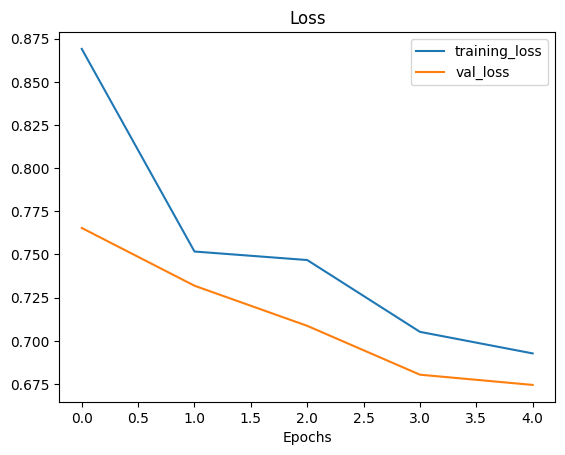

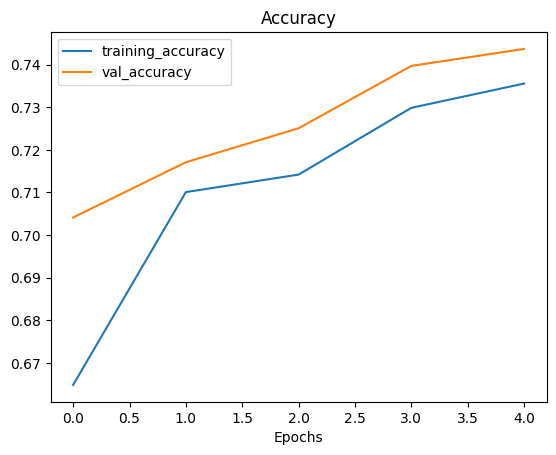

In [ ]:
# Plot the loss curves of the model
plot_loss_curves(history_model_2)

### Model 3: Conv1D with character embeddings

Previously, we used token-level embeddings, but here we will be doing char-level embeddings

#### Creating a character-level tokenizer

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'w h e n   c o m p a r e d   t o   p r i m a r y   l a i v   i n f e c t i o n   ,   t h e   d e c r e a s e d   f r e q u e n c y   o f   s h e d d i n g   w i t h   t h e   i i v - l a i v   s c h e d u l e   w a s   s i g n i f i c a n t   (   p   =   @   )   .'

In [ ]:
# Split the sequence level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# Getting the average character lengnth
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

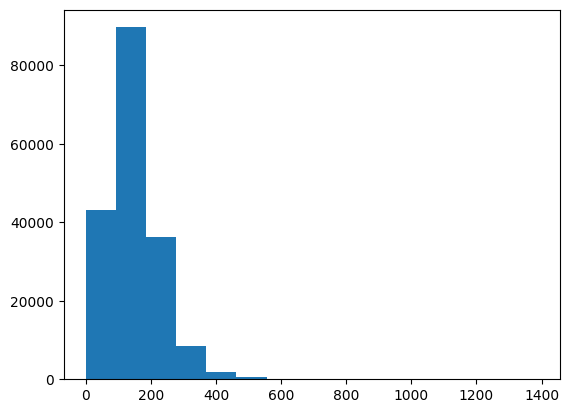

In [ ]:
# Check the distribution of the sequences at the character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=15);

In [ ]:
# Find the character length which covers 95% of the sequence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all alphanumeric characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
random.choice(train_sentences)

'central obesity in polycystic ovary syndrome ( pcos ) is associated with increased inflammatory markers and increased risk for type @ diabetes .'

In [ ]:
# Create char=level vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2  # adding 2 for space and OOV case (out of voacbulary)
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize='lower_and_strip_punctuation',
                                    name="char_vectorizer")

In [ ]:
# Adapt the char_vectorizer to the training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character voacb stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_char = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_char[0]}")
print(f"\nLength of vectorized chars: {len(vectorized_char[0])}")

Charified text:
 t h e   a i m   o f   t h e   p r e s e n t   s t u d y   w a s   t o   e v a l u a t e   t h e   e f f e c t   o f   o r a l   c a f f e i n e   i n g e s t i o n   d u r i n g   r e p e a t e d   s e t s   o f   r e s i s t a n c e   .

Length of random_train_chars: 99

Vectorized chars:
 [ 3 13  2  5  4 15  7 17  3 13  2 14  8  2  9  2  6  3  9  3 16 10 19 20
  5  9  3  7  2 21  5 12 16  5  3  2  3 13  2  2 17 17  2 11  3  7 17  7
  8  5 12 11  5 17 17  2  4  6  2  4  6 18  2  9  3  4  7  6 10 16  8  4
  6 18  8  2 14  2  5  3  2 10  9  2  3  9  7 17  8  2  9  4  9  3  5  6
 11  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 

#### Creating a character-level embedding

In [ ]:
# Creating the embedding layer
char_embed = layers.Embedding(input_dim = len(char_vocab),  # number of different characters
                              output_dim = 25,
                              mask_zero = True,
                              name = "char_embed" )

In [ ]:
# Test out the character-embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (After char-vectorization and embedding)\n: {char_embed_example}")
print(f"\nCharacter embedding shape: {char_embed_example.shape}")

Charified text:
 t h e   a i m   o f   t h e   p r e s e n t   s t u d y   w a s   t o   e v a l u a t e   t h e   e f f e c t   o f   o r a l   c a f f e i n e   i n g e s t i o n   d u r i n g   r e p e a t e d   s e t s   o f   r e s i s t a n c e   .

Embedded chars (After char-vectorization and embedding)
: [[[-0.03804092  0.01215642 -0.04470177 ...  0.00138521  0.04698328
   -0.04722755]
  [ 0.03012085 -0.04837496  0.0313989  ... -0.01603148  0.02904798
    0.01309708]
  [ 0.04087194 -0.0293079  -0.02609041 ... -0.00167333  0.04366375
    0.03326912]
  ...
  [-0.01610221  0.01201652 -0.02024795 ...  0.01849357  0.0350848
   -0.03629923]
  [-0.01610221  0.01201652 -0.02024795 ...  0.01849357  0.0350848
   -0.03629923]
  [-0.01610221  0.01201652 -0.02024795 ...  0.01849357  0.0350848
   -0.03629923]]]

Character embedding shape: (1, 290, 25)


In [ ]:
len(random_train_chars)

237

#### Create char-level datasets

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

#### Building a Conv1D with the character-level embedding

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape = (1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=10, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_char_embeddings")

# Compile the model
model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
# Getting the summary of the model
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           16064     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 

In [ ]:
# Fit the model to the char-level data
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*(len(train_char_dataset))),
                              epochs = 5,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/5
562/562 [==============================] - 7s 8ms/step - loss: 1.2145 - accuracy: 0.5056 - val_loss: 0.9925 - val_accuracy: 0.6144
Epoch 2/5
562/562 [==============================] - 4s 6ms/step - loss: 0.9535 - accuracy: 0.6253 - val_loss: 0.8912 - val_accuracy: 0.6622
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.8725 - accuracy: 0.6579 - val_loss: 0.8142 - val_accuracy: 0.6882
Epoch 4/5
562/562 [==============================] - 6s 11ms/step - loss: 0.8218 - accuracy: 0.6862 - val_loss: 0.7812 - val_accuracy: 0.6978
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.7975 - accuracy: 0.6963 - val_loss: 0.7609 - val_accuracy: 0.7141


In [ ]:
# Making predictions with the char-model
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.30975246, 0.4027107 , 0.13589516, 0.13440627, 0.01723542],
       [0.28187105, 0.38601303, 0.01201093, 0.3148706 , 0.00523446],
       [0.14048102, 0.15935169, 0.05568144, 0.6389682 , 0.00551762],
       ...,
       [0.01559316, 0.02532586, 0.05184079, 0.00408707, 0.9031531 ],
       [0.06963889, 0.2172507 , 0.20399056, 0.15179357, 0.35732627],
       [0.27563068, 0.62177575, 0.0775426 , 0.02086406, 0.0041869 ]],
      dtype=float32)

In [ ]:
# Convert the prediction probabilities to class lab3els
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate the results for the model_3
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 70.72024361180988,
 'precision': 0.7074271786807809,
 'recall': 0.7072024361180987,
 'f1': 0.7020685619705866}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

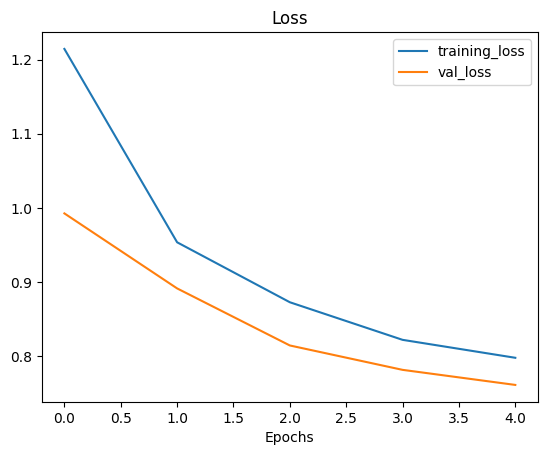

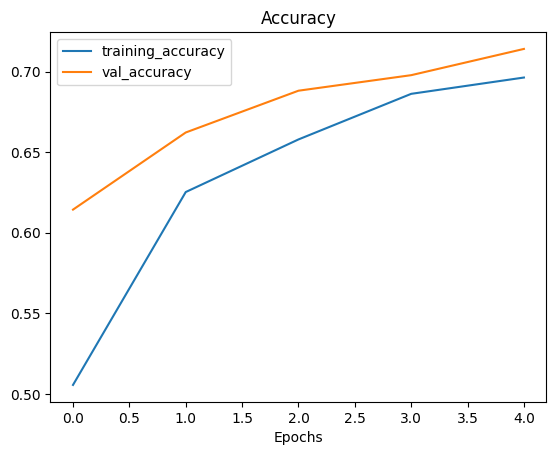

In [ ]:
# Plot the loss curves of the model
plot_loss_curves(model_3_history)

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid model)

Steps to create the model:               
1. Create a token-level embedding model (similar to `model_1`)                   
2. Create a character-level model (similar to `model_3` with some modifications)                           
3. Combine 1 and 2 with a concatenate layer (`layers.Concatenate`)             
4. Build a series of output layers on top of 3                                 
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs / model
token_inputs = layers.Input(shape = [], dtype = tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs = token_outputs)

# 2. Setup character-level input/output model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Combine token and char inputs with layers.Concatenate (hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                    char_model.output])

# 4. Create output layers - adding in Dropout layer
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs = output_layer,
                         name = "model_4_token_char_embeddings")

In [ ]:
# Getting the summary of the model
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['

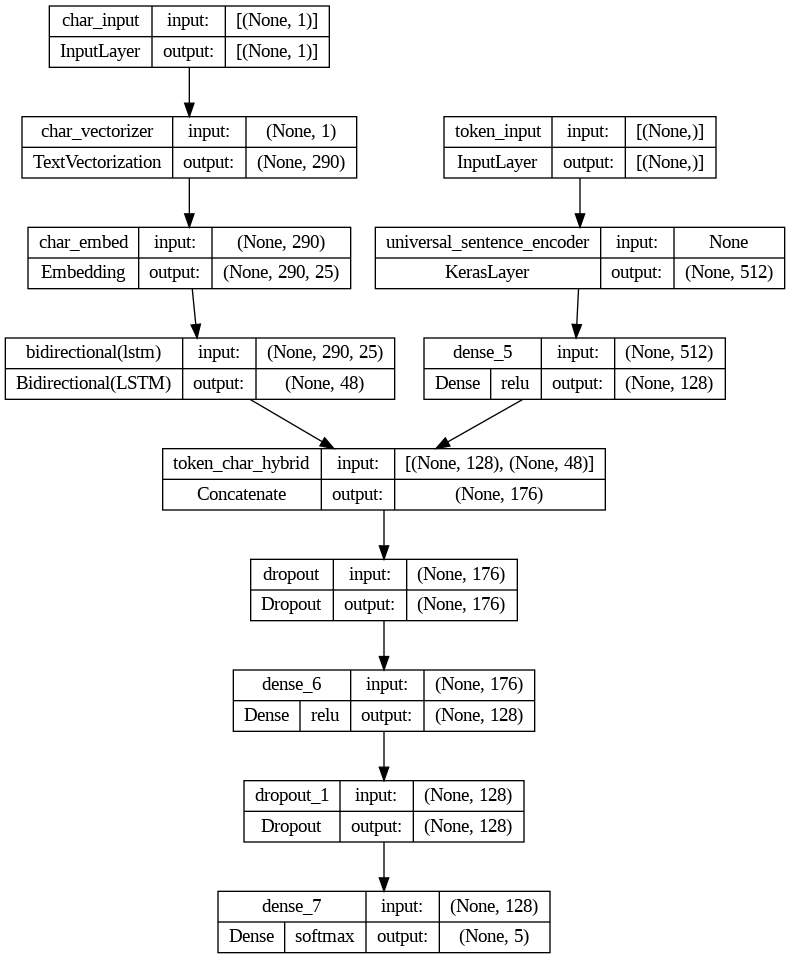

In [ ]:
# Visualize and plot the model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True,show_layer_activations=True)

In [ ]:
# Compile the char model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#### Combining token and character data into a tf.data dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))  # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)  # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))  # combine data and labels

# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat above steps for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))  # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)  # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))  # combine data and labels

# prefetch and batch validation data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Checkout the training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

Remember to keep the token-level and character-level data in same order as the input given to the network.

(Here, token-level comes before character-level data)

#### Fitting the model on token and character-level sequences

In [ ]:
# Fit the model
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.3*len(train_char_token_dataset)),
                              epochs = 5,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/5
1688/1688 [==============================] - 149s 77ms/step - loss: 0.8523 - accuracy: 0.6676 - val_loss: 0.6829 - val_accuracy: 0.7463
Epoch 2/5
1688/1688 [==============================] - 104s 62ms/step - loss: 0.7413 - accuracy: 0.7198 - val_loss: 0.6375 - val_accuracy: 0.7640
Epoch 3/5
1688/1688 [==============================] - 96s 57ms/step - loss: 0.7072 - accuracy: 0.7328 - val_loss: 0.6293 - val_accuracy: 0.7616
Epoch 4/5
 563/1688 [=========>....................] - ETA: 1:05 - loss: 0.6990 - accuracy: 0.7364

1688/1688 [==============================] - 36s 21ms/step - loss: 0.6990 - accuracy: 0.7364 - val_loss: 0.6228 - val_accuracy: 0.7699


In [ ]:
# Evaluate the model on the validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 24s 25ms/step - loss: 0.6234 - accuracy: 0.7629


[0.6233609318733215, 0.7628756761550903]

In [ ]:
# Predict using the model and obtain the prediction probabilities
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:5]

945/945 [==============================] - 23s 22ms/step


array([[0.513235  , 0.2833578 , 0.00197379, 0.193316  , 0.00811743],
       [0.40828428, 0.48722526, 0.00244498, 0.10079514, 0.00125034],
       [0.50469583, 0.01121312, 0.01570756, 0.4661488 , 0.00223467],
       [0.02329631, 0.02275762, 0.8169664 , 0.0233225 , 0.11365713],
       [0.00334978, 0.01411981, 0.8183261 , 0.00224604, 0.16195817]],
      dtype=float32)

In [ ]:
# Convert the prediction probalities into labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 0, 2, 2, 4, 2, 2, 4, 1])>

In [ ]:
# Calculate the results of the model
model_4_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 76.28756785383291,
 'precision': 0.7605782162352859,
 'recall': 0.7628756785383292,
 'f1': 0.7586403968349923}

In [ ]:
model_1_results

{'accuracy': 80.09069244009002,
 'precision': 0.8007064927609412,
 'recall': 0.8009069244009003,
 'f1': 0.7977112436277302}

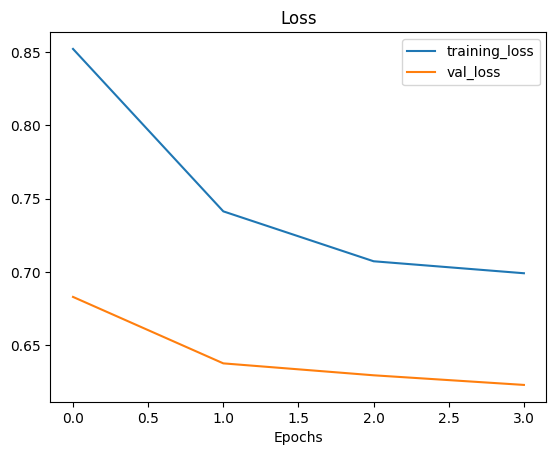

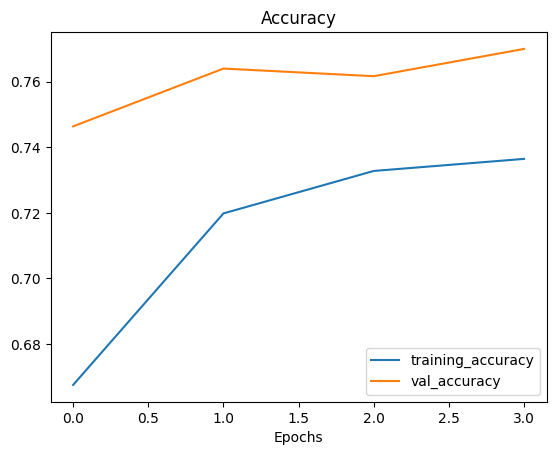

In [ ]:
# Plot the loss curves of the model
plot_loss_curves(model_4_history)

### Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

`NOTE`: Any engineered features used to train the model, needs to be available at test time.
Here, what we require is the line-number of the particular line and total lines of the abstract.

These will be used to create positional embeddings.

#### Creating positional embeddings

In [ ]:
# Checking out the different line numbers present
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

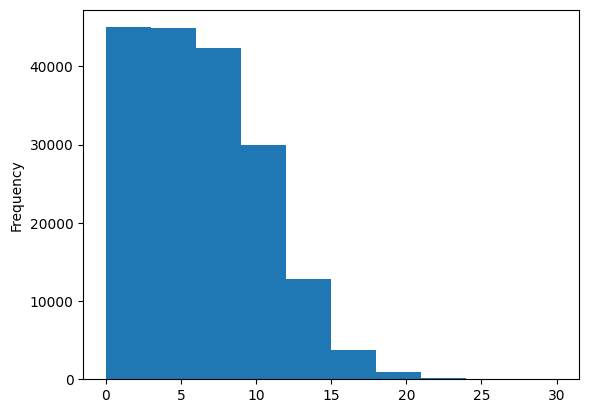

In [ ]:
# Checking the distribution of the line-number column
train_df.line_number.plot.hist()

In [ ]:
# Using tensorflow to create one-hot-encode the line-numbers
# this is to prevent the model from thinking that these are something like priority orders, etc.
# since the distribution is also unbalanced
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),
                                        depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now, encoding the total lines feature

In [ ]:
# Checking out the different total lines present
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

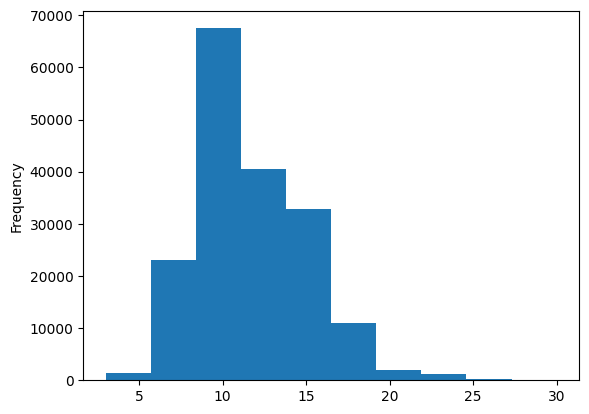

In [ ]:
# Plot the distribution of the total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of the 'total_lines' 95%ile
np.percentile(train_df.total_lines, 95)

18.0

In [ ]:
# Check the coverage of the 'total_lines' value 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Using tensorflow to one-hot encode the 'total_line' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

#### Building a tribrid embedding model

Steps to create the model:               
1. Create a token-level model            
2. Create a character-level model        
3. Create a model for the 'line-number' feature                                  
4. Create a model for 'total-lines' feature                                  
5. Combine the outputs fo 1 and 2 using tf.keras.Concatenate                     
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate              
7. Create an outputs layer to acccept the tribrid embedding and output label probabilities.                           
8. Combine the inputs of 1,2,3,4 and outputs into a tf.keras.Model

In [ ]:
train_line_numbers_one_hot[0].shape, train_line_numbers_one_hot[0].dtype

(TensorShape([15]), tf.float32)

In [ ]:
train_total_lines_one_hot[0].shape, train_total_lines_one_hot[0].dtype

(TensorShape([20]), tf.float32)

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Character inputs
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name ='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype = tf.float32, name='line_number_inputs')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = x)

# 4. Total line model
total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(inputs = total_line_inputs,
                                  outputs = y)

# 5. Combine token and char embeddings into a hybrid embeddins
combined_embeddings = layers.Concatenate(name='char_token_hybrid_embedding')([token_model.output,
                                                                              char_model.output])
# 5.b Pass the model through a dropout layer
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name='char_token_positional_embedding')([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together the model with all the inputs
model_5 = tf.keras.Model(inputs = [line_number_model.inputs,
                                   total_line_model.inputs,
                                   token_model.inputs,
                                   char_model.inputs
                                   ],
                         outputs = output_layer,
                         name = 'model_5_tribrid_model')

In [ ]:
# Checking out the summary of the model
model_5.summary()

Model: "model_5_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_in

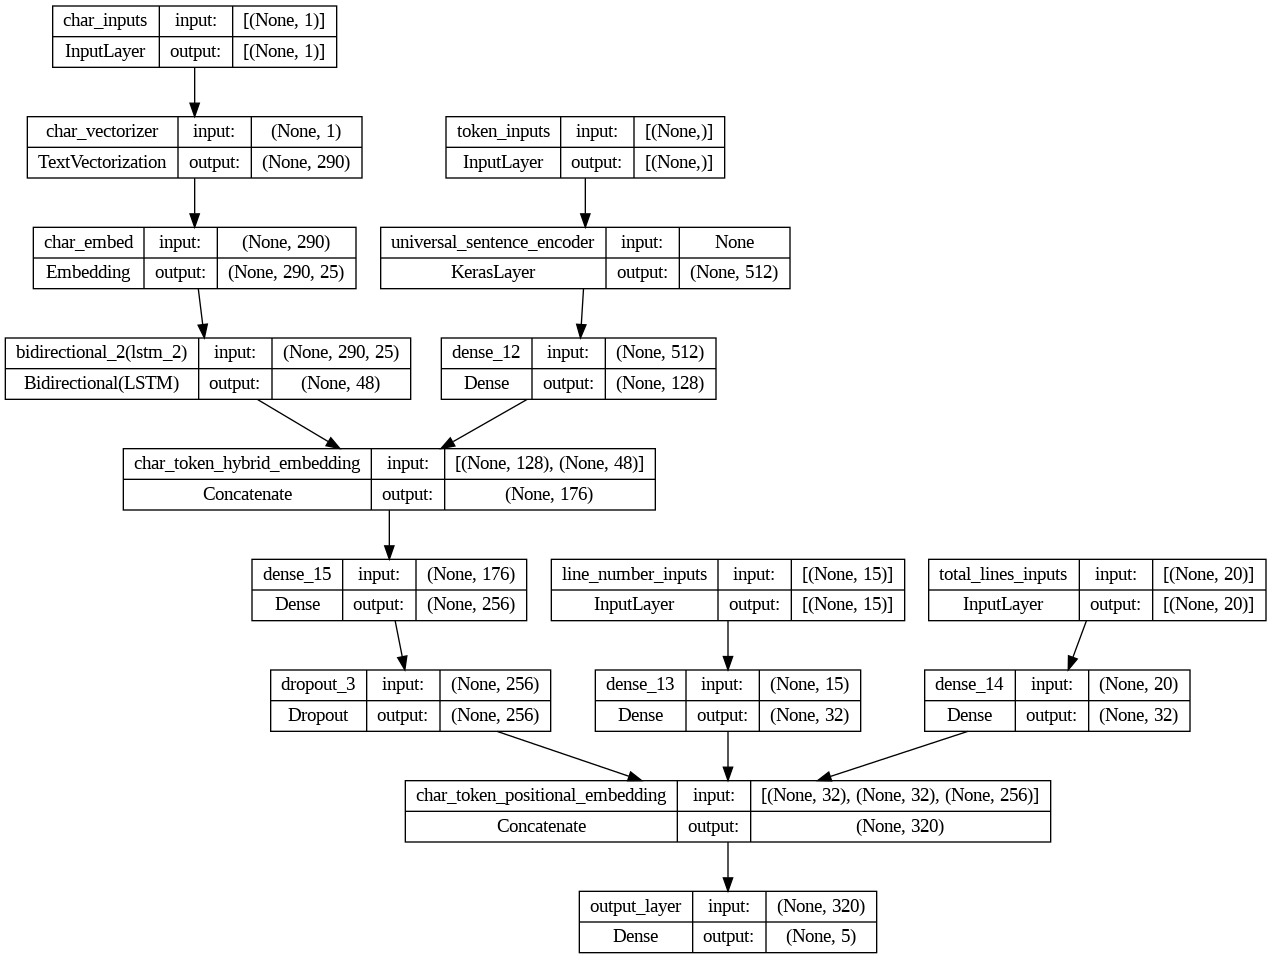

In [ ]:
# Plot and visualize the model
plot_model(model_5, show_shapes=True)

`label-smoothing`

In cases, where the model gets to confident on a single class (i.e. pred probs of that class is really high), it may get stuck on that class and not consider other classes.

Really confident prediction eg. : `[0.0, 0.0, 0.0, 1.0, 0.0]`

What label-smoothing does is that it assigns some of the value from the highest pred prob to the other classes, in hopes of improving the generalization of the model. eg. `[0.01, 0.01, 0.01, 0.96, 0.01]`

In [ ]:
# Compile the tribrid model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),   # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

#### Creating tribrid embedding datasets using tf.data

In [ ]:
# Create training datasets with all kinds of the data
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create validation datasets with all kinds of the data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset, len(train_char_token_pos_dataset)

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 5627)

In [ ]:
val_char_token_pos_dataset, len(val_char_token_pos_dataset)

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 945)

#### Fitting and evaluating the tribrid model with the tribrid dataset

In [ ]:
# Fit the tribrid model
model_5_history = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_pos_dataset)),
                              epochs = 5,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/5
562/562 [==============================] - 48s 57ms/step - loss: 1.0917 - accuracy: 0.7305 - val_loss: 0.9833 - val_accuracy: 0.7999
Epoch 2/5
562/562 [==============================] - 29s 51ms/step - loss: 0.9665 - accuracy: 0.8163 - val_loss: 0.9488 - val_accuracy: 0.8305
Epoch 3/5
562/562 [==============================] - 32s 56ms/step - loss: 0.9499 - accuracy: 0.8239 - val_loss: 0.9361 - val_accuracy: 0.8338
Epoch 4/5
562/562 [==============================] - 31s 55ms/step - loss: 0.9380 - accuracy: 0.8362 - val_loss: 0.9278 - val_accuracy: 0.8354
Epoch 5/5
562/562 [==============================] - 47s 83ms/step - loss: 0.9357 - accuracy: 0.8375 - val_loss: 0.9218 - val_accuracy: 0.8434


In [ ]:
# Evaluate the model on the whole validation data
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 32s 34ms/step - loss: 0.9204 - accuracy: 0.8433


[0.9203606247901917, 0.8433403968811035]

In [ ]:
# Make predictions using the tribrid model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_pred_probs[:10]

945/945 [==============================] - 38s 36ms/step


array([[0.5938781 , 0.07156271, 0.01223344, 0.3013061 , 0.02101961],
       [0.6269016 , 0.08150607, 0.08226508, 0.19769877, 0.01162837],
       [0.36588657, 0.10343321, 0.1491934 , 0.33210403, 0.04938283],
       [0.03725656, 0.06223923, 0.7899478 , 0.03356308, 0.07699333],
       [0.03915624, 0.02970253, 0.83184916, 0.03744212, 0.06184996],
       [0.01301016, 0.04402144, 0.3976692 , 0.01894131, 0.5263579 ],
       [0.01489792, 0.05972969, 0.2430388 , 0.02235183, 0.6599817 ],
       [0.01142926, 0.10674962, 0.22902149, 0.0203176 , 0.63248205],
       [0.02399793, 0.0869349 , 0.05692989, 0.03276531, 0.79937196],
       [0.04102461, 0.6540568 , 0.04329725, 0.0360493 , 0.22557206]],
      dtype=float32)

In [ ]:
# Convert the prediction probabilities to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the model results
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 84.33403945452139,
 'precision': 0.847117399656631,
 'recall': 0.8433403945452138,
 'f1': 0.8392951578209543}

In [ ]:
model_4_results

{'accuracy': 76.28756785383291,
 'precision': 0.7605782162352859,
 'recall': 0.7628756785383292,
 'f1': 0.7586403968349923}

In [ ]:
model_1_results

{'accuracy': 80.09069244009002,
 'precision': 0.8007064927609412,
 'recall': 0.8009069244009003,
 'f1': 0.7977112436277302}

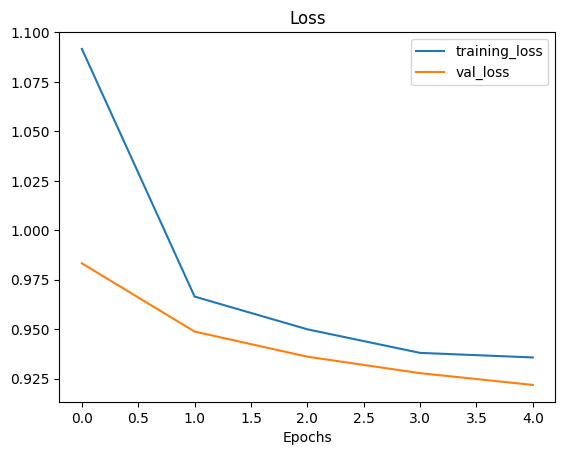

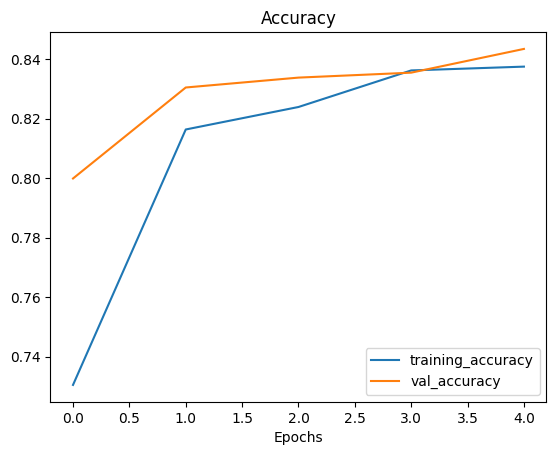

In [ ]:
# Plot the loss curves of the model
plot_loss_curves(model_5_history)

### Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,80.090692,0.800706,0.800907,0.797711
model_2_pretrained_token_embedding,74.112935,0.735930,0.741129,0.736184
model_3_custom_char_embedding,70.720244,0.707427,0.707202,0.702069
model_4_hybrid_char_token_embedding,76.287568,0.760578,0.762876,0.758640
model_5_pos_char_token_embedding,84.334039,0.847117,0.843340,0.839295


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

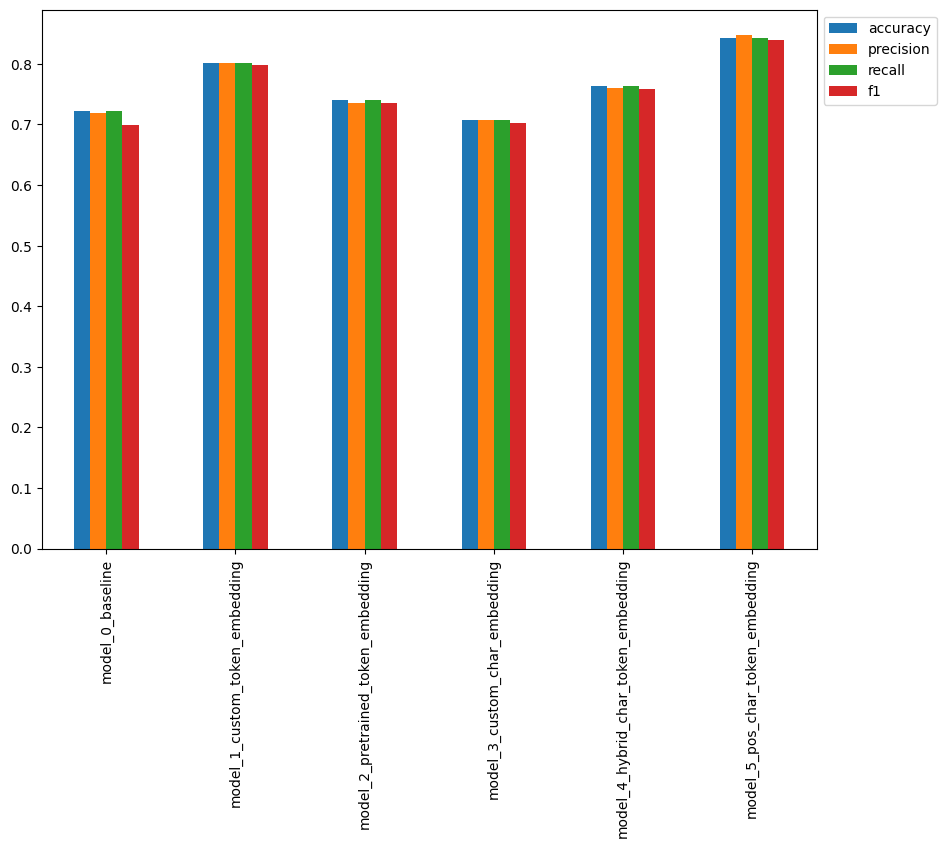

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

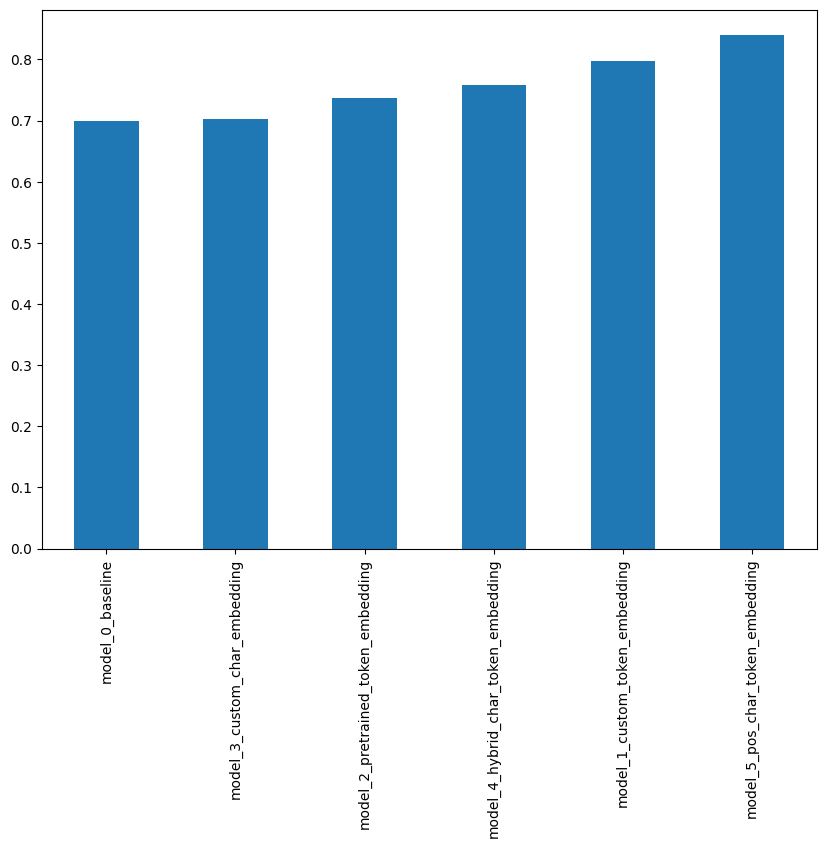

In [ ]:
# Sort the models results by f1-score
all_model_results.sort_values("f1", ascending=True)['f1'].plot(kind='bar', figsize=(10, 7))

### Save and load the best model

In [ ]:
# Save the best performing model to SavedModel format (default format)
model_5.save('skimlit_tribrid_model')

In [ ]:
# Load in the model
loaded_model = tf.keras.models.load_model('skimlit_tribrid_model')

In [ ]:
# Make prediction using the loaded model
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 25s 27ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_model_results = calculate_results(y_true = val_labels_encoded,
                                          y_pred = loaded_preds)
loaded_model_results

{'accuracy': 84.33403945452139,
 'precision': 0.847117399656631,
 'recall': 0.8433403945452138,
 'f1': 0.8392951578209543}

In [ ]:
model_5_results

{'accuracy': 84.33403945452139,
 'precision': 0.847117399656631,
 'recall': 0.8433403945452138,
 'f1': 0.8392951578209543}

In [ ]:
# Check if the results as true
model_5_results == loaded_model_results

True

In [ ]:
# Check the loaded model summary
loaded_model.summary()

Model: "model_5_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_in